In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
df_results = pd.read_csv('data/results.csv')
df_results = df_results[['raceId', 'driverId', 'constructorId', 'grid', 'position']]

df_constructors = pd.read_csv('data/constructors.csv')

df_drivers = pd.read_csv('data/drivers.csv')

df_races = pd.read_csv('data/races.csv')




In [3]:
df_merge = df_results.merge(df_drivers[['driverId', 'driverRef']], on='driverId', how='left')
df_merge = df_merge.merge(df_constructors[['constructorId', 'constructorRef']], on='constructorId', how='left')
df_merge = df_merge.merge(df_races[['raceId', 'circuitId', 'year', 'round']], on='raceId', how='left')
df_merge


df_merge['podium'] = df_merge['position'].isin(['1', '2', '3'])
df_merge = df_merge.sort_values(['year', 'round'])

# filter to after 1980
df_merge = df_merge[df_merge['year'] > 1980]

# last year podium rate
def get_last_year_podium_rate(group):
    result = []
    for idx, row in group.iterrows():
        current_year = row['year']
        last_year_data = group[(group['year'] == current_year - 1)]
        if len(last_year_data) > 0:
            rate = last_year_data['podium'].mean()
        else:
            rate = np.nan
        result.append(rate)
    return pd.Series(result, index=group.index)

df_merge['podium_rate_last_year'] = df_merge.groupby('driverId').apply(get_last_year_podium_rate).reset_index(level=0, drop=True)

# current year podium rate up to last race
def get_current_year_podium_rate(group):
    result = []
    for idx, row in group.iterrows():
        current_year = row['year']
        current_round = row['round']
        current_year_data = group[(group['year'] == current_year) & (group['round'] < current_round)]
        if len(current_year_data) > 0:
            rate = current_year_data['podium'].mean()
        else:
            rate = np.nan
        result.append(rate)
    return pd.Series(result, index=group.index)

df_merge['podium_rate_curr_year'] = df_merge.groupby('driverId').apply(get_current_year_podium_rate).reset_index(level=0, drop=True)

# 3. all time podium rate til current race
df_merge['podium_rate_all_time'] = df_merge.groupby('driverId')['podium'].apply(
    lambda x: x.expanding().mean().shift(1)
).reset_index(level=0, drop=True)

# drop unnecessary columns
df_merge = df_merge.drop(columns=['raceId', 'driverId', 'constructorId', 'circuitId', 'position'])


df_merge

C:\Users\danie\AppData\Local\Temp\ipykernel_15764\338921975.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_merge['podium_rate_last_year'] = df_merge.groupby('driverId').apply(get_last_year_podium_rate).reset_index(level=0, drop=True)
C:\Users\danie\AppData\Local\Temp\ipykernel_15764\338921975.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_merge['podium_rate_curr_year'] = df_merge.groupby('driverId')

,grid,driverRef,constructorRef,year,round,podium,podium_rate_last_year,podium_rate_curr_year,podium_rate_all_time
11544,2,jones,williams,1981,1,True,NaN,NaN,NaN
11545,3,reutemann,williams,1981,1,True,NaN,NaN,NaN
11546,4,piquet,brabham,1981,1,True,NaN,NaN,NaN
11547,6,mario_andretti,alfa,1981,1,False,NaN,NaN,NaN
11548,8,cheever,tyrrell,1981,1,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
26754,14,kevin_magnussen,haas,2024,24,False,0.000000,0.000000,0.005405
26755,12,lawson,rb,2024,24,False,0.000000,0.000000,0.000000
26756,9,bottas,sauber,2024,24,False,0.000000,0.000000,0.272358
26757,20,colapinto,williams,2024,24,False,NaN,0.000000,0.000000


In [4]:
# check for null
df_merge.isnull().sum()

# this is probably okay, since it could be someone's first year, a season's first race, or the person has never gotten a podium before

grid                        0
driverRef                   0
constructorRef              0
year                        0
round                       0
podium                      0
podium_rate_last_year    3825
podium_rate_curr_year    1263
podium_rate_all_time      275
dtype: int64

In [5]:
df_merge = df_merge.fillna(0) # default value to 0
df_merge.isnull().sum()


grid                     0
driverRef                0
constructorRef           0
year                     0
round                    0
podium                   0
podium_rate_last_year    0
podium_rate_curr_year    0
podium_rate_all_time     0
dtype: int64

In [6]:
# split data into train validation and test

from sklearn.model_selection import train_test_split


df_full_train, df_test = train_test_split(df_merge, test_size=0.2)
df_train, df_val = train_test_split(df_full_train, test_size=0.25)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


y_train = (df_train.podium).astype('int').values
y_val = (df_val.podium).astype('int').values
y_test = (df_test.podium).astype('int').values
y_full_train = (df_full_train.podium).astype('int').values

# Remove target variable from features to prevent leakage
del df_train['podium']

del df_val['podium']

del df_test['podium']

del df_full_train['podium']


In [7]:
# imports

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score, recall_score


# Logistic regression 

In [8]:
# first we use dv to do one-hot encoding

train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [9]:
# now we use the validation dataset to get y_pred
val_dicts = df_val.to_dict(orient = 'records')
X_val = dv.transform(val_dicts)

y_pred = lr.predict_proba(X_val)[:, 1]


# and we get how this performs
auc = roc_auc_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred > 0.5)
avg_precision = average_precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred > 0.5)
auc, accuracy, avg_precision, recall


(0.9176344950705245,
 0.897289972899729,
 0.6308514785452198,
 0.44123711340206184)

In [10]:
# now we train the final model with the full train data

full_train_dicts = df_full_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(full_train_dicts)

lr = LogisticRegression(max_iter=10000)
lr.fit(X_full_train, y_full_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [11]:
# Test the model with Verstappen at Zandvoort


test_example = {
    'grid': 1,  # lets say he qualified in the front
    'driverRef': 'max_verstappen',
    'constructorRef': 'haas',
    'year': 2028,
    'round': 15,  
    'podium_rate_last_year': 0.82,  
    'podium_rate_curr_year': 0.85,  
    'podium_rate_all_time': 0.65   
}

# Transform and predict
test_dict = [test_example]
X_test_example = dv.transform(test_dict)

verstappen_prob = lr.predict_proba(X_test_example)[:, 1][0]

print(f"probability of podium: {verstappen_prob:.2%}")
print(f"prediction: {'Podium' if verstappen_prob > 0.5 else 'No Podium'}")


# we can see that even max cant save a haas and bring it to podium

probability of podium: 28.36%
prediction: No Podium


## random forest

now we will try to get a better model with the random forest classifier

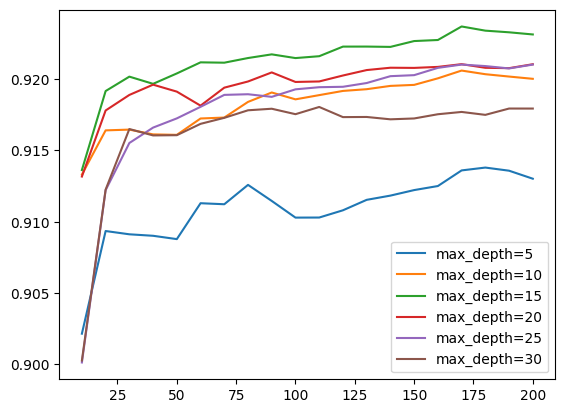

In [12]:
# lets start with the depth

scores = []

for d in [5, 10, 15, 20, 25, 30]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))
        
    
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

for d in [5, 10, 15, 20, 25, 30]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

Looks like 20 is the best, lets do 20

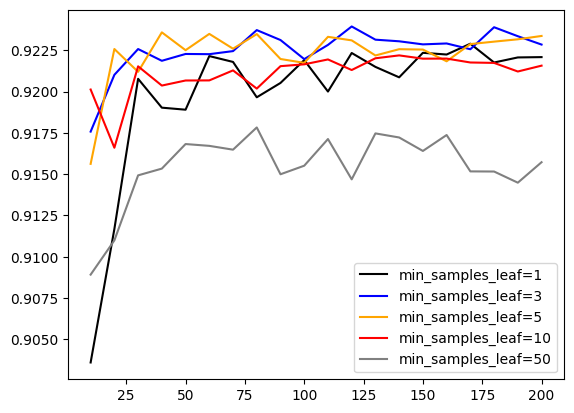

In [13]:

scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=20,
                                    min_samples_leaf=s,)
        rf.fit(X_train, y_train)
        
        
        
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))
        
        
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

3 looks pretty good, especially at 165

In [14]:
# lets train the model with the right params



rf = RandomForestClassifier(n_estimators=165,
                            max_depth=20,
                            min_samples_leaf=3,)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
# and we get how this performs
auc = roc_auc_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred > 0.5)
avg_precision = average_precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred > 0.5)
auc, accuracy, avg_precision, recall




(0.923737073194268, 0.8948509485094851, 0.6356721278951002, 0.3711340206185567)

In [15]:
# now lets do the final model with both train and val


# now we train the final model with the full train data

full_train_dicts = df_full_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(full_train_dicts)

rf = RandomForestClassifier(n_estimators=165,
                            max_depth=20,
                            min_samples_leaf=3,)
rf.fit(X_full_train, y_full_train)

,n_estimators,165
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
# Test the model with Verstappen at Zandvoort again


test_example = {
    'grid': 1,  # lets say he qualified in the front
    'driverRef': 'max_verstappen',
    'constructorRef': 'haas',
    'year': 2028,
    'round': 15,  
    'podium_rate_last_year': 0.82,  
    'podium_rate_curr_year': 0.85,  
    'podium_rate_all_time': 0.65   
}

# Transform and predict
test_dict = [test_example]
X_test_example = dv.transform(test_dict)

verstappen_prob = rf.predict_proba(X_test_example)[:, 1][0]

print(f"probability of podium: {verstappen_prob:.2%}")
print(f"prediction: {'Podium' if verstappen_prob > 0.5 else 'No Podium'}")


# we can see that with this model max can bring a haas to the podium because he is a good driver

probability of podium: 62.18%
prediction: Podium


# Gradient Boosting with XGBoost

In [28]:
import xgboost as xgb


In [29]:

# remade dv 
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [34]:
# loop to get best params
watchlist = [(dtrain, 'train'), (dval, 'val')]

scores = []

for e in [0.01, 0.05, 0.1, 0.3]:
    for d in [3, 5, 7, 10]:
        for s in [1, 3, 5, 10]:
            xgb_params = {
                'eta': e, 
                'max_depth': d,
                'min_child_weight': s,
                
                'objective': 'binary:logistic',
                'eval_metric': 'auc',

                'nthread': 8,
                'seed': 1,
                'verbosity': 1,
            }
            
            model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                              verbose_eval=50,
                              evals=watchlist,
                              early_stopping_rounds=10)
            
            # use best score from early stopping
            best_auc = model.best_score
            scores.append((e, d, s, best_auc))

# display results
columns = ['eta', 'max_depth', 'min_child_weight', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values('auc', ascending=False).head(10)


[0]	train-auc:0.90761	val-auc:0.90088
[50]	train-auc:0.92468	val-auc:0.91727
[95]	train-auc:0.92673	val-auc:0.91916
[0]	train-auc:0.90761	val-auc:0.90088
[50]	train-auc:0.92458	val-auc:0.91718
[100]	train-auc:0.92701	val-auc:0.91975
[150]	train-auc:0.92846	val-auc:0.92166
[167]	train-auc:0.92863	val-auc:0.92180
[0]	train-auc:0.90761	val-auc:0.90088
[50]	train-auc:0.92458	val-auc:0.91718
[100]	train-auc:0.92701	val-auc:0.91975
[150]	train-auc:0.92822	val-auc:0.92170
[180]	train-auc:0.92846	val-auc:0.92213
[0]	train-auc:0.90761	val-auc:0.90088
[46]	train-auc:0.92288	val-auc:0.91650
[0]	train-auc:0.92522	val-auc:0.91219
[50]	train-auc:0.93668	val-auc:0.92189
[58]	train-auc:0.93698	val-auc:0.92194
[0]	train-auc:0.92579	val-auc:0.91385
[50]	train-auc:0.93587	val-auc:0.92122
[81]	train-auc:0.93694	val-auc:0.92151
[0]	train-auc:0.92628	val-auc:0.91579
[50]	train-auc:0.93535	val-auc:0.92230
[61]	train-auc:0.93572	val-auc:0.92232
[0]	train-auc:0.92625	val-auc:0.91513
[50]	train-auc:0.93401	val-

,eta,max_depth,min_child_weight,auc
32,0.10,3,1,0.925839
16,0.05,3,1,0.925551
33,0.10,3,3,0.925463
35,0.10,3,10,0.925454
34,0.10,3,5,0.925382
49,0.30,3,3,0.925288
17,0.05,3,3,0.925245
19,0.05,3,10,0.925211
50,0.30,3,5,0.925064
51,0.30,3,10,0.924860


In [ ]:
# now lets train the final model with the good params

# Get best params from grid search
best_params = df_scores.iloc[0]

xgb_params = {
    'eta': best_params['eta'], 
    'max_depth': int(best_params['max_depth']),
    'min_child_weight': int(best_params['min_child_weight']),

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# get full train
full_train_dicts = df_full_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(full_train_dicts)
features = list(dv.get_feature_names_out())
dfull_train = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=features)

# Train final model on full training data
final_model = xgb.train(xgb_params, dfull_train, num_boost_round=200)


In [ ]:
# final xgb model test

test_example = {
    'grid': 10,  
    'driverRef': 'max_verstappen',
    'constructorRef': 'redbull',
    'year': 2028,
    'round': 15,  
    'podium_rate_last_year': 0.92,  
    'podium_rate_curr_year': 1,  
    'podium_rate_all_time': 0.85   
}

# Transform and predict
test_dict = [test_example]
X_test_example = dv.transform(test_dict)
dtest = xgb.DMatrix(X_test_example, feature_names=features)

verstappen_prob = final_model.predict(dtest)[0]

print(f"probability of podium: {verstappen_prob:.2%}")
print(f"prediction: {'Podium' if verstappen_prob > 0.5 else 'No Podium'}")


probability of podium: 33.76%
prediction: No Podium
